In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import pymc3 as pm
import scipy as sp
import pyccl as ccl
import os
import utils
from make_data import MakeData
import getdist
from getdist import plots, MCSamples
from os import listdir
from os.path import isfile, join
import yaml
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rc('legend',fontsize=14)

%matplotlib inline

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Load data

In [2]:
names_planck  = ['H0_gp', 'Omega_m', 's80', 'S80']
labels_planck = [r'H_0', r'\Omega_{\rm{m}}', r'\sigma_{\rm{8}}',  r'\S_{\rm{8}}']

planck1 = np.loadtxt('/home/jaime/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_1.txt')
planck2 = np.loadtxt('/home/jaime/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_2.txt')
planck3 = np.loadtxt('/home/jaime/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_3.txt')
planck4 = np.loadtxt('/home/jaime/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_4.txt')

planck_tot = np.concatenate((planck1, planck2, planck3, planck4), axis=0)

planck_params = []
for item in planck_tot:
    planck_params.append([item[29], item[31], item[34], item[35]])
planck_params = np.array(planck_params)
planck_samples = MCSamples(samples=planck_params, names = names_planck, labels = labels_planck, label= r'$Planck$ 2018',
                    weights=np.transpose(planck_tot)[0],loglikes=np.transpose(planck_tot)[1])

Removed no burn in


In [3]:
z_max = 1110
res = 200
x_arr = np.linspace(0, np.log(1+z_max), res)
dx = np.mean(np.diff(x_arr))
z_arr = np.exp(x_arr)-1
a_arr = 1./(1+z_arr)

path = '/home/jaime/PhD/Growz/data/products/'

data_class = MakeData(z_max, res , path)
Planck = data_class.Planck
z_planck = data_class.z_planck
c = data_class.c

DESI_data = data_class.get_DESI(new=True, mode=None)
WFIRST_data = data_class.get_WFIRST(new=False)
CC_data = data_class.get_CC(new=False)
DSS_data = data_class.get_DSS(new=False)
BOSS_data = data_class.get_BOSS(new=False)
eBOSS_data = data_class.get_eBOSS(new=False)
Wigglez_data = data_class.get_Wigglez(new=False)
DS17_data = data_class.get_DS17(new=False)
CMB_data = data_class.get_CMB(new=False)
FCMB_data = data_class.get_FCMB(new=False)

Using Planck mean
Found file for WFIRST
Found file for CC
Found file for DSS
Found file for BOSS
Found file for eBOSS
Found file for Wigglez
Found file for DS17
Found file for CMB
Found file for FCMB


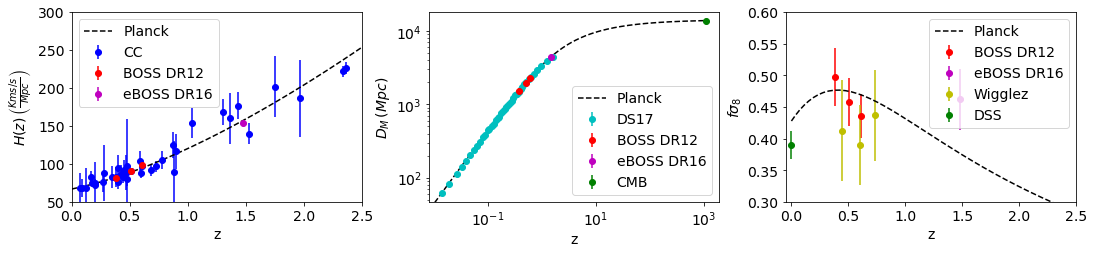

In [4]:
fig=plt.figure(figsize=(18,3.5))
fig.subplots_adjust(wspace=0.23)

ax1 = plt.subplot(131)
plt.plot(z_planck, Planck['Hkms_arr'], "k--", label='Planck')
plt.errorbar(CC_data['z'], CC_data['data'], yerr = CC_data['err'], fmt='bo', label='CC')
plt.errorbar(BOSS_data['z'], BOSS_data['para_data'], yerr=BOSS_data['para_err'], fmt='ro', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], c/1000/(eBOSS_data['para_data']*eBOSS_data['rd']), 
             yerr = 1/eBOSS_data['rd']/(np.array([0.47])), fmt='mo', label='eBOSS DR16')
# axis labels and title
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

ax1 = plt.subplot(132)
plt.plot(z_planck, Planck['dM_arr'], "k--", label='Planck')
plt.errorbar(DS17_data['z'], (10**((DS17_data['data']-25+19.4)/5))/(1+DS17_data['z']),
             yerr=(10**(DS17_data['err']/5))/(1+DS17_data['z']), fmt='co', label='DS17')
plt.errorbar(BOSS_data['z'], BOSS_data['perp_data'], yerr=BOSS_data['perp_err'], fmt='ro', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['perp_data']*eBOSS_data['rd'], 
             yerr=np.array([0.79])*eBOSS_data['rd'], fmt='mo', label='eBOSS DR16')
plt.errorbar(CMB_data['z'], (1/CMB_data['data'])*(100*CMB_data['rd']), 
             yerr=(1/CMB_data['err'])*1/(100*CMB_data['rd']), fmt='go', label='CMB')

plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.loglog()
plt.ylabel(r"$D_M \, (Mpc)$")
plt.legend();

ax1 = plt.subplot(133)
plt.plot(z_planck, Planck['f_arr']*Planck['s8_arr'], "k--", label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='ro', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='mo', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='yo', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='go', label='DSS')

plt.xlim(-0.05, 2.5)
plt.ylim(0.3, 0.6)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/data.pdf', bbox_inches='tight', pad_inches=0)


In [5]:
def get_m_s(rows):
    cols = np.transpose(rows)
    means = np.array([])
    sigmas = np.array([])
    for col in cols:
        mean = np.mean(col)
        sigma = np.std(col)
        means = np.append(means, mean)
        sigmas = np.append(sigmas, sigma)
    return means, sigmas

In [6]:
#LCDM 
path = '/home/jaime/PhD/Growz/data/outputs/LCDM/'
fiducial_LCDM = np.load(os.path.join(path,'LCDM_All_CMB_Planck_10001_10001/samples.npz'))
DESI_LCDM = np.load(os.path.join(path,'LCDM_DESI_CMB_Planck_10001_10001/samples.npz'))

path = '/home/jaime/PhD/Growz/data/outputs/finals/'
All_CMB = np.load(os.path.join(path, 'All_CMB_Planck_95_2500_2500/samples.npz'))
All_CMB_90 = np.load(os.path.join(path, 'All_CMB_Planck_90_2500_2500/samples.npz'))
All_CMB_hp = np.load(os.path.join(path,'All_CMB_Planck_l_0.001_n_0.1_3000_3000/samples.npz'))
#All_CMB_noA0 = np.load(os.path.join(path, 'All_CMB_best_fit_noA0_3000_3000/samples.npz'))
All_CMB_NODSS = np.load(os.path.join(path, 'All_CMB_NODSS_Planck_5000_5000/samples.npz'))
All_CMB_bfWms8 = np.load(os.path.join(path, 'All_CMB_Planck_bfWms8_3000_3000/samples.npz'))
#All_CMB_geo = np.load(os.path.join(path,'All_CMB_geo_Planck_5000_5000/samples.npz'))
All = np.load(os.path.join(path,'All_Planck_3000_3000/samples.npz'))
#All_gro = np.load(os.path.join(path,'All_gro_Planck_A0_50000_50000/samples.npz'))
DESI_CMB = np.load(os.path.join(path, 'DESI_CMB_Planck_3001_3001/samples.npz'))

path = '/home/jaime/PhD/Growz/data/outputs/reruns/'
All_CMB2 = np.load(os.path.join(path, 'All_CMB_Planck_3000_7000/samples.npz'))
#All_CMB_90 = np.load(os.path.join(path, 'All_CMB_Planck_90_2500_2500/samples.npz'))
#All_CMB_hp = np.load(os.path.join(path,'All_CMB_Planck_l_0.001_n_0.1_3000_3000/samples.npz'))
All_CMB_noA0 = np.load(os.path.join(path, 'All_CMB_best_fit_noA0_3000_3000/samples.npz'))
#All_CMB_NODSS = np.load(os.path.join(path, 'All_CMB_NODSS_Planck_5000_5000/samples.npz'))
#All_CMB_bfWms8 = np.load(os.path.join(path, 'All_CMB_Planck_bfWms8_3000_3000/samples.npz'))
All_CMB_geo = np.load(os.path.join(path,'All_CMB_geo_Planck_5000_3000/samples.npz'))
All_CMB_geo2 = np.load(os.path.join(path,'All_CMB_geo_Planck_3000_7000/samples.npz'))
#All = np.load(os.path.join(path,'All_Planck_3000_3000/samples.npz'))
All_gro = np.load(os.path.join(path,'All_gro_Planck_5000_3000/samples.npz'))
DESI_CMB2 = np.load(os.path.join(path, 'DESI_CMB_Planck_3000_7000/samples.npz'))


# Numbers

In [7]:
def table_numbers(samples, sample_names):
    no_cosmo = ['Geometry data', 'All data (BF $\Omega_m$ and $\sigma_8$)']
    no_dHz = ['All data ($\Lambda$CDM)', 'DESI $+$ CMB ($\Lambda$CDM)']
    table = {}
    for i, sample in enumerate(samples):
        print(sample_names[i])
        table[sample_names[i]] = {}
        
        if 'n' in sample.files  is not None:
            n = sample['n']
            n_m = np.mean(n)
            n_s = np.std(n)
        else:
            n_m = 0
            n_s = 0
        print('n', n_m, '+/-', n_s)
        table[sample_names[i]]['n_m'] = n_m
        table[sample_names[i]]['n_s'] = n_s
        
        if 'H0_gp' in sample.files:
            H0 = sample['H0_gp']
            H0_m = np.mean(H0)
            H0_s = np.std(H0)
        else:
            H0_m = 0
            H0_s = 0
        print('H0', H0_m, '+/-', H0_s)
        table[sample_names[i]]['H0_m'] = H0_m
        table[sample_names[i]]['H0_s'] = H0_s
        
        if 'S80' in sample.files and sample_names[i] not in no_cosmo:
            S80 = sample['S80']
            S80_m = np.mean(S80)
            S80_s = np.std(S80)
        else:
            S80_m = 0
            S80_s = 0
        print('S80', S80_m, '+/-', S80_s)
        table[sample_names[i]]['S80_m'] = S80_m
        table[sample_names[i]]['S80_s'] = S80_s
        
        if 's80' in sample.files and sample_names[i] not in no_cosmo:
            s80 = sample['s80']
            s80_m = np.mean(s80)
            s80_s = np.std(s80)
        else:
            s80_m = 0
            s80_s = 0
        print('s80', s80_m, '+/-', s80_s)
        table[sample_names[i]]['s80_m'] = s80_m
        table[sample_names[i]]['s80_s'] = s80_s
        
        if 'Omega_m' in sample.files and sample_names[i] not in no_cosmo:
            Wm = sample['Omega_m']
            Wm_m = np.mean(Wm)
            Wm_s = np.std(Wm)
        else:
            Wm_m = 0
            Wm_s = 0
        print('Wm0', Wm_m, '+/-', Wm_s)
        table[sample_names[i]]['Wm_m'] = Wm_m
        table[sample_names[i]]['Wm_s'] = Wm_s
        
        if 'DHz' in sample.files and sample_names[i] not in  no_dHz:
            varH = np.std(sample['DHz'],0)
            varH_m = np.mean(varH)
            varH_s = np.std(varH)
        else:
            varH = np.std(sample['Hz']/data_class.H_arr-1, 1)
            varH_m = np.mean(varH)
            varH_s = np.std(varH)
        print('varH', varH_m, '+/-', varH_s)
        table[sample_names[i]]['varH_m'] = varH_m
        table[sample_names[i]]['varH_s'] = varH_s
        print('-----')
        
    return table

In [8]:
numbers = table_numbers([fiducial_LCDM, DESI_LCDM, All_CMB,  All_CMB_bfWms8, All_CMB_hp,   All_CMB_noA0,  All, 
               All_CMB_NODSS,   All_gro, All_CMB_geo, DESI_CMB],
              ['All data ($\Lambda$CDM)', 'DESI+CMB ($\Lambda$CDM)', 'All data', 'All data (BF $\Omega_m$ and $\sigma_8$)',
               'All data (Fixed HP)', 'All data (Two-Steps)', 'No CMB',
               'No DSS', 'Growth data', 'Geometry data', 'DESI $+$ CMB'])

All data ($\Lambda$CDM)
n 0 +/- 0
H0 67.75707741387875 +/- 0.7880817803134922
S80 0.7844841084617252 +/- 0.028941627594235783
s80 0.7872667067894293 +/- 0.028623029134826797
Wm0 0.29796168548331226 +/- 0.0073462378567382275
varH 0.00575997586873007 +/- 0.0024331540351843466
-----
DESI+CMB ($\Lambda$CDM)
n 0 +/- 0
H0 67.34859730037839 +/- 0.15797731013183988
S80 0.8434473483222429 +/- 0.0012512341402632124
s80 0.8237845722203538 +/- 0.00030536803227786737
Wm0 0.31449305743093653 +/- 0.000968205155797352
varH 0.000371379545486265 +/- 0.0002466310534041951
-----
All data
n 0.11083005903519336 +/- 0.09686508149872709
H0 67.42178837806527 +/- 0.9739784155925495
S80 0.7926653071592058 +/- 0.03008396407574879
s80 0.9578956669294237 +/- 0.16016623684627992
Wm0 0.22008883544066812 +/- 0.06506061694846052
varH 0.08385129204006223 +/- 0.009756236305884201
-----
All data (BF $\Omega_m$ and $\sigma_8$)
n 0.1081135815140879 +/- 0.09185151113493766
H0 67.46164332114618 +/- 0.952606019456454
S80 0 +/-

In [9]:
def make_table(numbers):
    names = numbers.keys()
    for name in names:
        Wm = '${} \pm {}$'.format(round(numbers[name]['Wm_m'],3), round(numbers[name]['Wm_s'],3))
        s80 = '${} \pm {}$'.format(round(numbers[name]['s80_m'],3), round(numbers[name]['s80_s'],3))
        S80 = '${} \pm {}$'.format(round(numbers[name]['S80_m'],3), round(numbers[name]['S80_s'],3))
        H0 = '${} \pm {}$'.format(round(numbers[name]['H0_m'],3), round(numbers[name]['H0_s'],3))
        print(name, '&', Wm, '&',  s80, '&',  S80, '&',  H0, r'\\' )

In [10]:
def make_table2(numbers):
    names = numbers.keys()
    for name in names:
        varH = '${} \pm {}$'.format(round(numbers[name]['varH_m'],3), round(numbers[name]['varH_s'],3))
        n = '${} \pm {}$'.format(round(numbers[name]['n_m'],3), round(numbers[name]['n_s'],3))
        print(name, '&', n, '&', varH, r'\\' )

In [11]:
make_table(numbers)

All data ($\Lambda$CDM) & $0.298 \pm 0.007$ & $0.787 \pm 0.029$ & $0.784 \pm 0.029$ & $67.757 \pm 0.788$ \\
DESI+CMB ($\Lambda$CDM) & $0.314 \pm 0.001$ & $0.824 \pm 0.0$ & $0.843 \pm 0.001$ & $67.349 \pm 0.158$ \\
All data & $0.22 \pm 0.065$ & $0.958 \pm 0.16$ & $0.793 \pm 0.03$ & $67.422 \pm 0.974$ \\
All data (BF $\Omega_m$ and $\sigma_8$) & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $67.462 \pm 0.953$ \\
All data (Fixed HP) & $0.211 \pm 0.064$ & $0.984 \pm 0.18$ & $0.796 \pm 0.041$ & $67.805 \pm 3.522$ \\
All data (Two-Steps) & $0.225 \pm 0.067$ & $0.943 \pm 0.156$ & $0.789 \pm 0.028$ & $68.027 \pm 0.719$ \\
No CMB & $0.227 \pm 0.066$ & $0.933 \pm 0.15$ & $0.785 \pm 0.03$ & $68.004 \pm 1.014$ \\
No DSS & $0.24 \pm 0.112$ & $0.961 \pm 0.216$ & $0.799 \pm 0.047$ & $67.4 \pm 0.998$ \\
Growth data & $0.218 \pm 0.071$ & $0.982 \pm 0.198$ & $0.8 \pm 0.041$ & $68.072 \pm 18.588$ \\
Geometry data & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $67.456 \pm 0.97$ \\
DESI $+$ CMB & $0.313 \pm 0.012$ & $0.823 \

In [12]:
make_table2(numbers)

All data ($\Lambda$CDM) & $0 \pm 0$ & $0.006 \pm 0.002$ \\
DESI+CMB ($\Lambda$CDM) & $0 \pm 0$ & $0.0 \pm 0.0$ \\
All data & $0.111 \pm 0.097$ & $0.084 \pm 0.01$ \\
All data (BF $\Omega_m$ and $\sigma_8$) & $0.108 \pm 0.092$ & $0.082 \pm 0.011$ \\
All data (Fixed HP) & $0 \pm 0$ & $0.095 \pm 0.013$ \\
All data (Two-Steps) & $0.022 \pm 0.02$ & $0.017 \pm 0.004$ \\
No CMB & $0.203 \pm 0.132$ & $0.132 \pm 0.035$ \\
No DSS & $0.108 \pm 0.1$ & $0.08 \pm 0.009$ \\
Growth data & $0.147 \pm 0.114$ & $0.183 \pm 0.003$ \\
Geometry data & $0.086 \pm 0.069$ & $0.075 \pm 0.007$ \\
DESI $+$ CMB & $0.073 \pm 0.068$ & $0.064 \pm 0.003$ \\


# 1D Comp

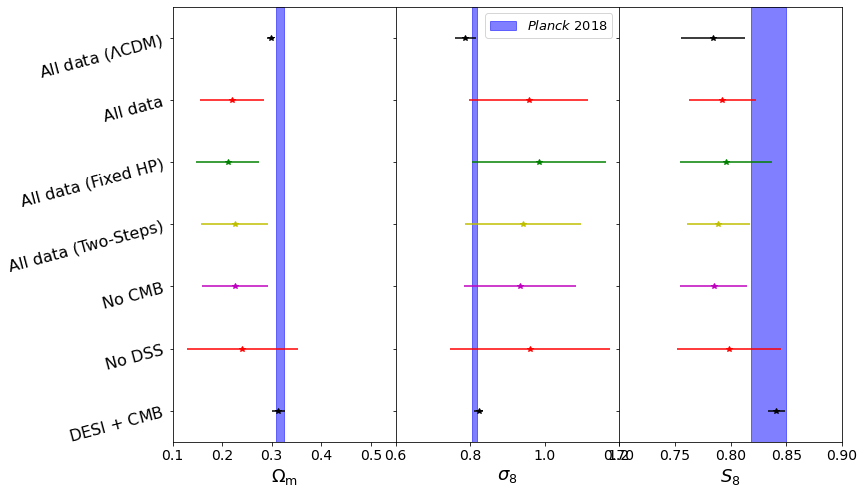

In [13]:
fig=plt.figure(figsize=(12,8))
fig.subplots_adjust(wspace=0)

my_yticks = ['All data ($\Lambda$CDM)', 'All data', 'All data (Fixed HP)', 'All data (Two-Steps)', 'No CMB',
               'No DSS', 'DESI $+$ CMB']

fmts = {'All data ($\Lambda$CDM)': 'k*',
        'All data': 'r*',
        'All data (Fixed HP)': 'g*',
        'All data (Two-Steps)': 'y*',
        'No CMB': 'm*',
        'No DSS': 'r*', 
        'DESI $+$ CMB': 'k*'}

y = {'All data ($\Lambda$CDM)': 0,
    'All data': 2,
    'All data (Fixed HP)': 4,
    'All data (Two-Steps)': 6,
    'No CMB': 8,
    'No DSS': 10, 
    'DESI $+$ CMB': 12}

ax1 = plt.subplot(131)
label = r'$\Omega_{\rm{m}}$'
plt.axvspan(0.3166 - 0.0084, 0.3166 + 0.0084, alpha = 0.5, color='b',  label= r'$Planck$ 2018')
for name in my_yticks:
    Wm=numbers[name]['Wm_m']
    Wm_err=numbers[name]['Wm_s']
    plt.errorbar( Wm, y[name], xerr=np.transpose(Wm_err), fmt=fmts[name])

plt.yticks(list(y.values()), list(y.keys()), fontsize=16)
plt.xlabel(label, fontsize=18)
plt.axis([0.1, 0.55, y[my_yticks[-1]]+1 ,-1,])
plt.yticks(rotation=15)
plt.xticks(fontsize=14)

    
ax2 = plt.subplot(132, sharey = ax1)
label = r'$\sigma_{\rm{8}}$'
plt.axvspan(0.8120 - 0.0073, 0.8120 + 0.0073, alpha = 0.5, color='b',  label= r'$Planck$ 2018')
for name in my_yticks:
    s8=numbers[name]['s80_m']
    s8_err=numbers[name]['s80_s']
    plt.errorbar( s8, y[name], xerr=np.transpose(s8_err), fmt=fmts[name])
plt.xlabel(label, fontsize=18)
plt.legend(loc = 1, prop={'size': 13})
plt.axis([0.6, 1.2, y[my_yticks[-1]]+1 ,-1,])
plt.setp( ax2.get_yticklabels(), visible=False)
plt.xticks(fontsize=14)
    
ax3 = plt.subplot(133, sharey = ax2)
label = r'$S_{\rm{8}}$'
plt.axvspan(0.834 - 0.016, 0.834 + 0.016, alpha = 0.5, color='b',  label= r'$Planck$ 2018')
for name in my_yticks:
    S8=numbers[name]['S80_m']
    S8_err=numbers[name]['S80_s']
    plt.errorbar( S8, y[name], xerr=np.transpose(S8_err), fmt=fmts[name])
plt.xlabel(label, fontsize=18)
#plt.legend(loc = 1, prop={'size': 13})
plt.axis([0.7, 0.9, y[my_yticks[-1]]+1 ,-1,])
plt.setp( ax3.get_yticklabels(), visible=False)
plt.xticks(fontsize=14)

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/1D_comp.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/1D_comp.pdf', bbox_inches='tight', pad_inches=0)

# Triangle Plots

In [14]:
def make_samples(file, names, ranges, label):
    namess = []
    labels = []
    samples = []
    for name in names:
        if name in file.keys():
            namess.append(name) 
            labels.append(labels_dict[name]) 
            samples.append(file[name]) 
        
    return MCSamples(samples=samples, names=namess, labels=labels, label=label, ranges=ranges,
                    settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.3})

In [15]:
labels_dict = {'n': '\eta',
               'l': 'l',
               'A0': 'A_0',
               'n_H': '\eta_H',
               'l_H': 'l_H',
               'n_Xi': '\eta_{Xi}',
               'l_Xi': 'l_{Xi}',
               'H0': 'H_0',
               'H0_gp': 'H_0',
               'omega_m': '\omega_m',
               'Omega_m': '\Omega_m',
               'Omega_m_mean': '\Omega_m^{mean}',
               'omega_b': '\omega_b',
               'Omega_m': '\Omega_m',
               'Omega_b': '\Omega_b',
               's80': '\sigma_8',
               'S80': 'S_8',
               'rd': 'r_s',
               'M': 'M'}
names_All = ['n', 'l', 'n_H', 'l_H', 'n_Xi', 'l_Xi', 'A0',
             'H0', 'H0_gp',  'Omega_m', 'omega_m', 'Omega_m_mean',
             'omega_b', 'Omega_m', 'Omega_b', 's80', 'S80', 'M']
ranges2 = {'l':[0.01, 6],}
ranges = {'l':[0.01, 6], 'Omega_m':[0.00, 0.5], 'n':[0, 1]}
ranges_c = {'H0_gp':[60, 80], 'Omega_m':[0.00, 0.5], 's80':[0, 1.2], 'S80':[0, 1]}

In [16]:
Fiducial_LCDM_samples = make_samples(fiducial_LCDM, ['H0_gp', 'Omega_m', 's80', 'S80', 'M', 'rd'], 
                                ranges, r'All data ($\Lambda$CDM)')
DESI_LCDM_samples = make_samples(DESI_LCDM, ['H0_gp', 'Omega_m', 's80', 'S80'], 
                                ranges, r'DESI+CMB ($\Lambda$CDM)')
All_CMB_samples = make_samples(All_CMB, ['A0', 'n', 'l', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd', 'M'],
                               ranges, 'All data')
All_CMB2_samples = make_samples(All_CMB2, ['A0', 'n', 'l', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd', 'M'],
                               ranges, 'All data rerun-longer')
All_CMB_noA0_samples = make_samples(All_CMB_noA0, ['n', 'l', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd', 'M'],
                               ranges, 'All data (Two-steps)')
All_CMB_hp_samples = make_samples(All_CMB_hp, ['A0', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd', 'M'],
                               ranges, 'All data (Fixed HP)')
All_samples = make_samples(All, ['A0', 'n', 'l', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd', 'M'],
                               ranges, 'No CMB')
All_CMB_NODSS_samples = make_samples(All_CMB_NODSS, ['A0', 'n', 'l', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd', 'M'],
                               ranges, 'No DSS')
All_gro_samples = make_samples(All_gro, ['A0', 'n', 'l', 'H0_gp', 'Omega_m', 's80', 'S80'],
                               ranges, 'Growth data')
All_CMB_geo_samples = make_samples(All_CMB_geo, ['A0', 'n', 'l', 'H0_gp'],
                               ranges, 'Geometry data')
All_CMB_geo2_samples = make_samples(All_CMB_geo2, ['A0', 'n', 'l', 'H0_gp'],
                               ranges, 'Geometry data longer')
All_CMB_bfWms8_samples = make_samples(All_CMB_bfWms8, ['n', 'l', 'H0_gp'],
                               ranges, 'All data (BF $\Omega_m$ and $\sigma_8$)')
DESI_CMB_samples = make_samples(DESI_CMB, ['A0','n', 'l', 'H0_gp', 'Omega_m', 's80', 'S80'], 
                                ranges, r' DESI+CMB')
DESI_CMB2_samples = make_samples(DESI_CMB2, ['A0','n', 'l', 'H0_gp', 'Omega_m', 's80', 'S80'], 
                                ranges, r' DESI+CMB rerun-longer')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


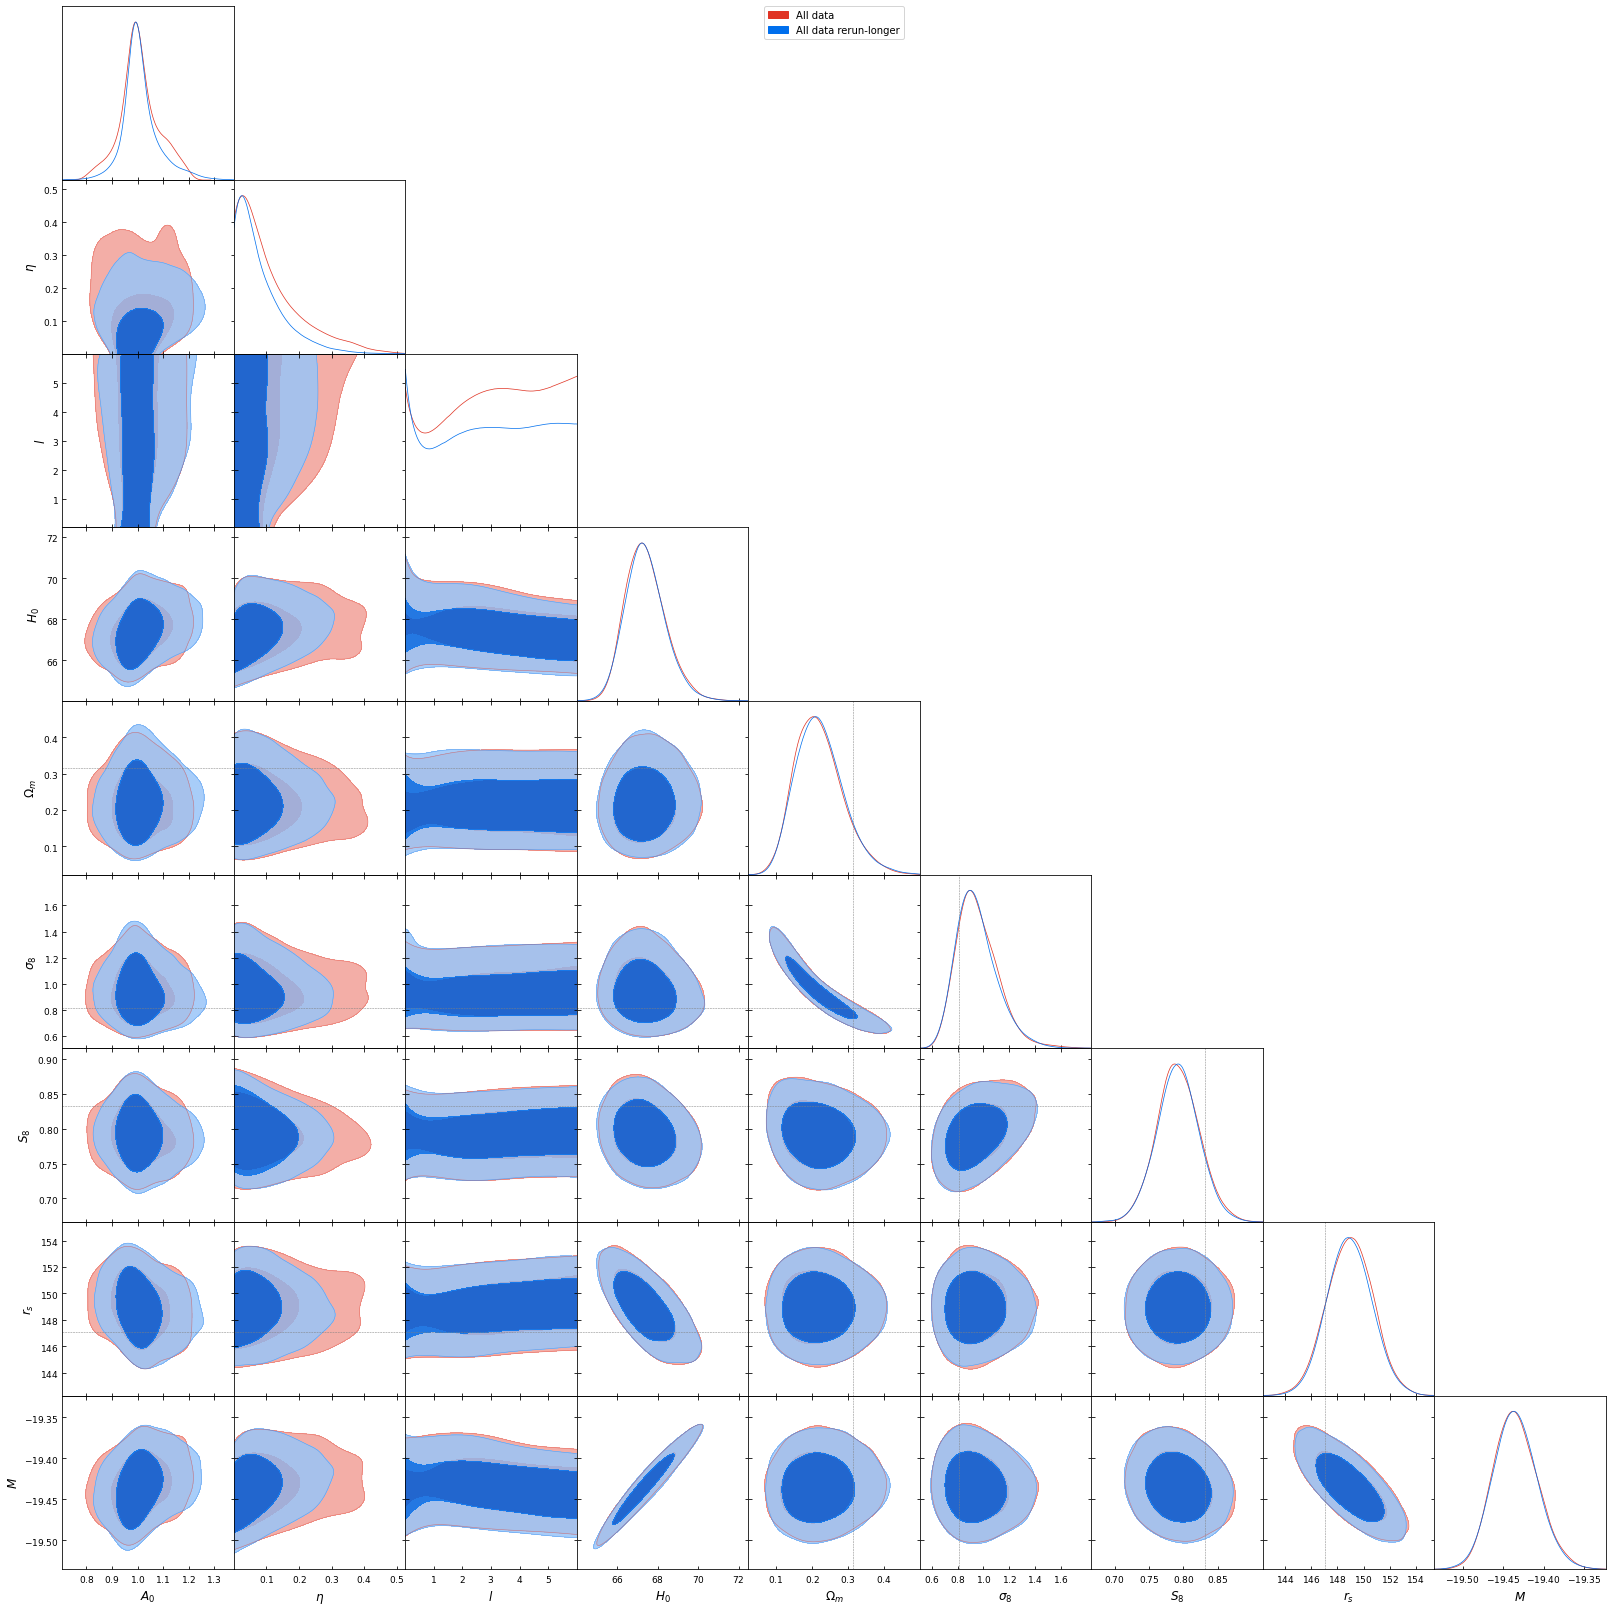

In [17]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([All_CMB_samples, All_CMB2_samples],
                #['H0_gp', 'Omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         'rd':147.06546072,
                         'M': -19.2})                

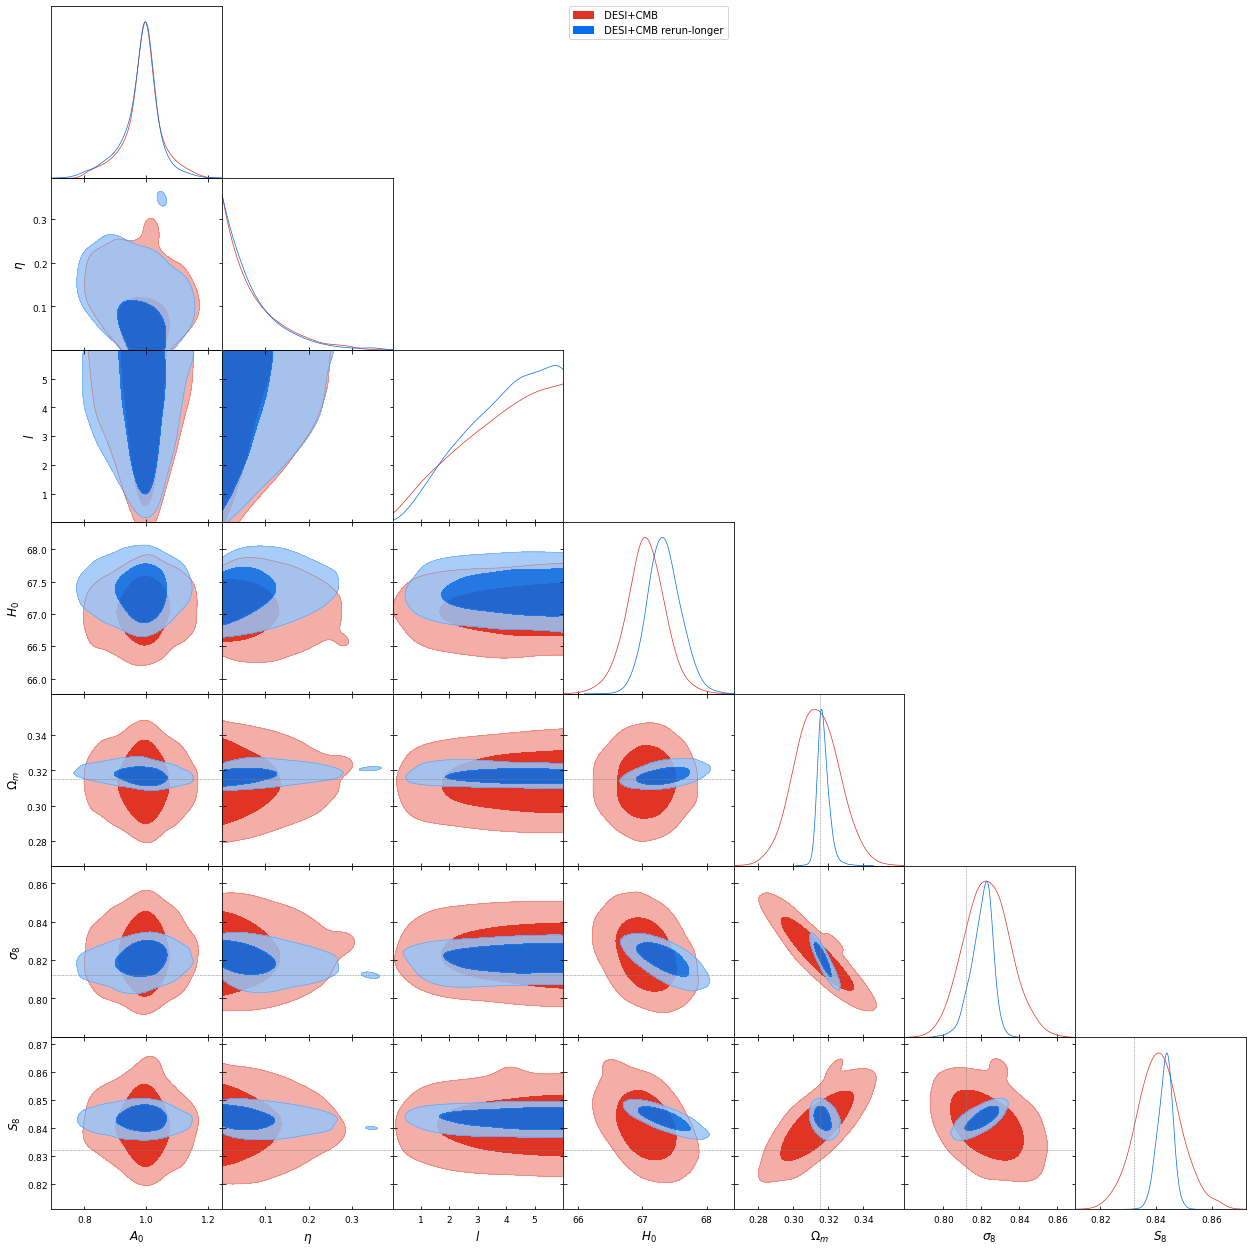

In [18]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([DESI_CMB_samples, DESI_CMB2_samples],
                #['H0_gp', 'Omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         'rd':147.06546072,
                         'M': -19.2})                

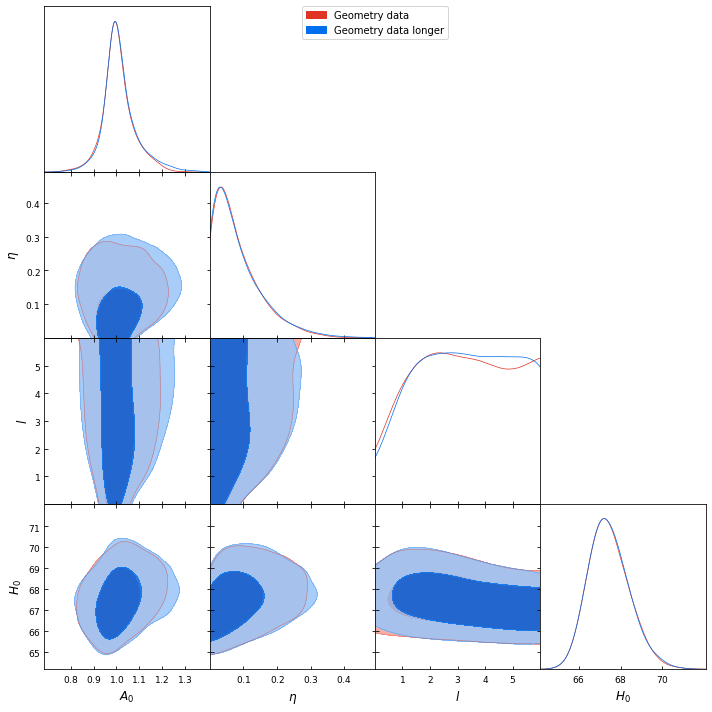

In [19]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([All_CMB_geo_samples, All_CMB_geo2_samples],
                #['H0_gp', 'Omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         'rd':147.06546072,
                         'M': -19.2})                

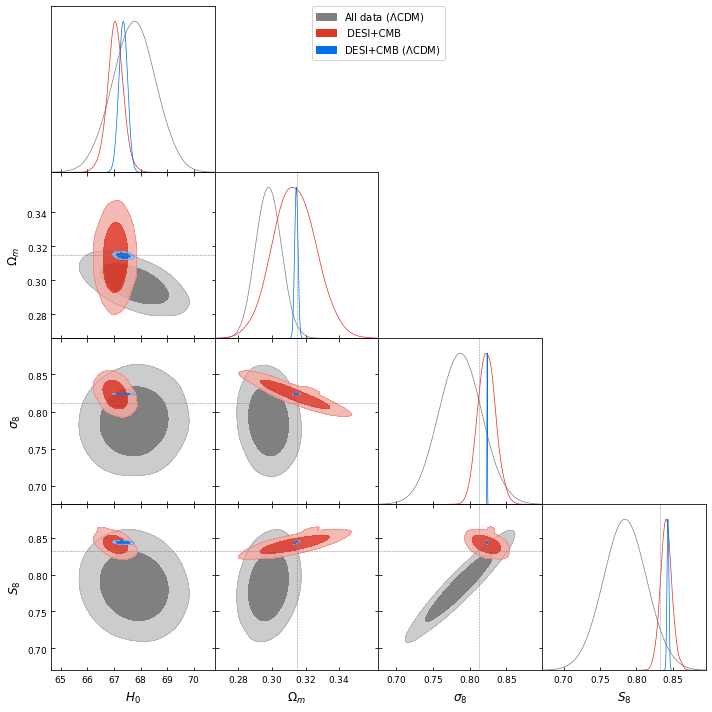

In [47]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([Fiducial_LCDM_samples, DESI_CMB_samples, DESI_LCDM_samples],
                ['H0_gp', 'Omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         'rd':147.06546072,
                         'M': -19.2})
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_forecast.pdf')                

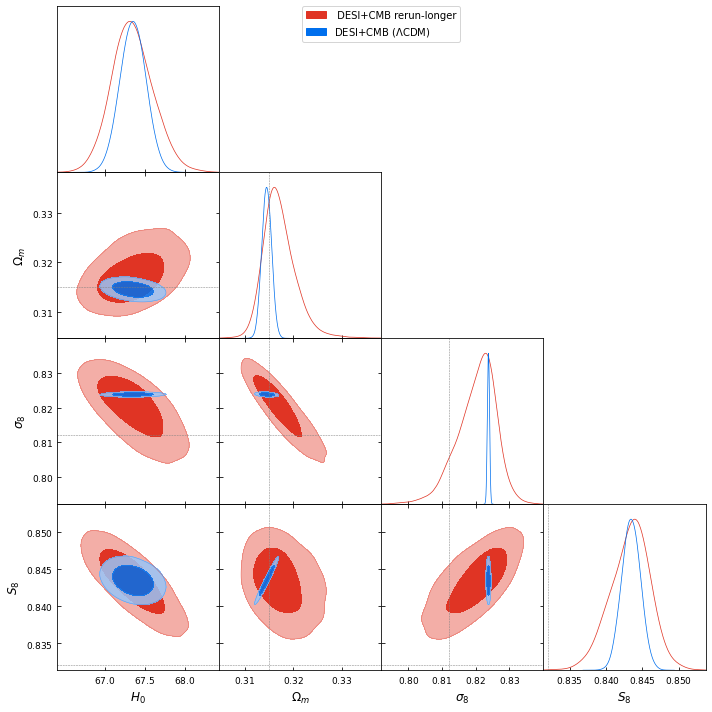

In [21]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([DESI_CMB2_samples, DESI_LCDM_samples],
                ['H0_gp', 'Omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         'rd':147.06546072,
                         'M': -19.2})
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_forecast.pdf')                

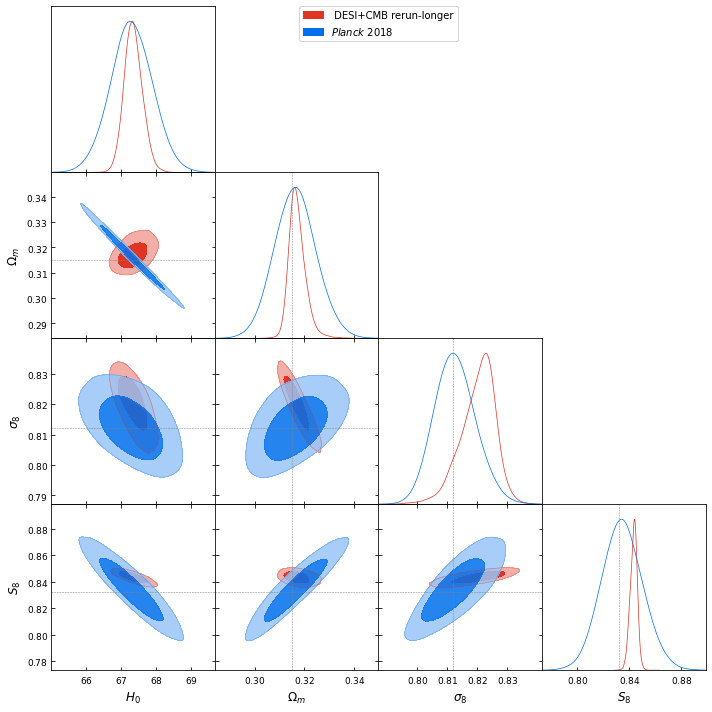

In [22]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([DESI_CMB2_samples, planck_samples],
                ['H0_gp', 'Omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         'rd':147.06546072,
                         'M': -19.2})
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_forecast.pdf')                

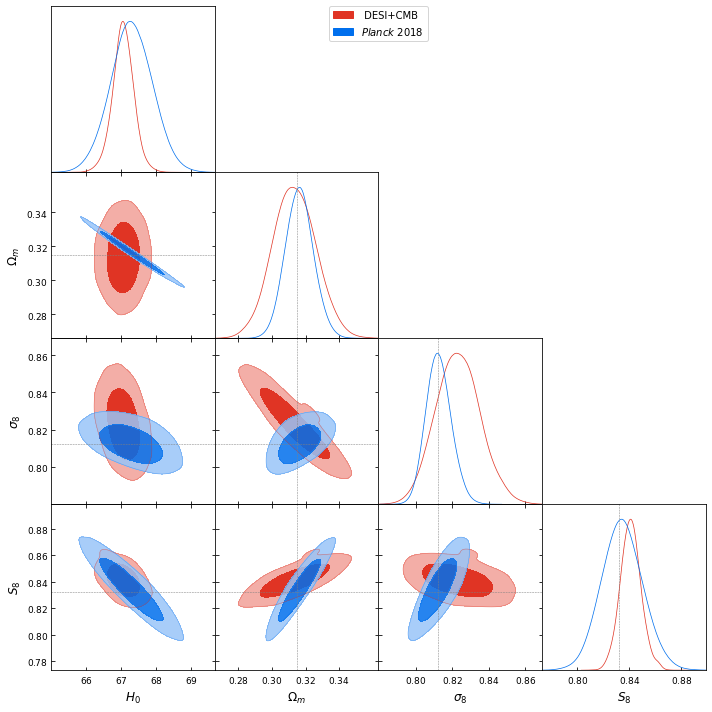

In [23]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([DESI_CMB_samples, planck_samples],
                ['H0_gp', 'Omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         'rd':147.06546072,
                         'M': -19.2})
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_forecast.pdf')                

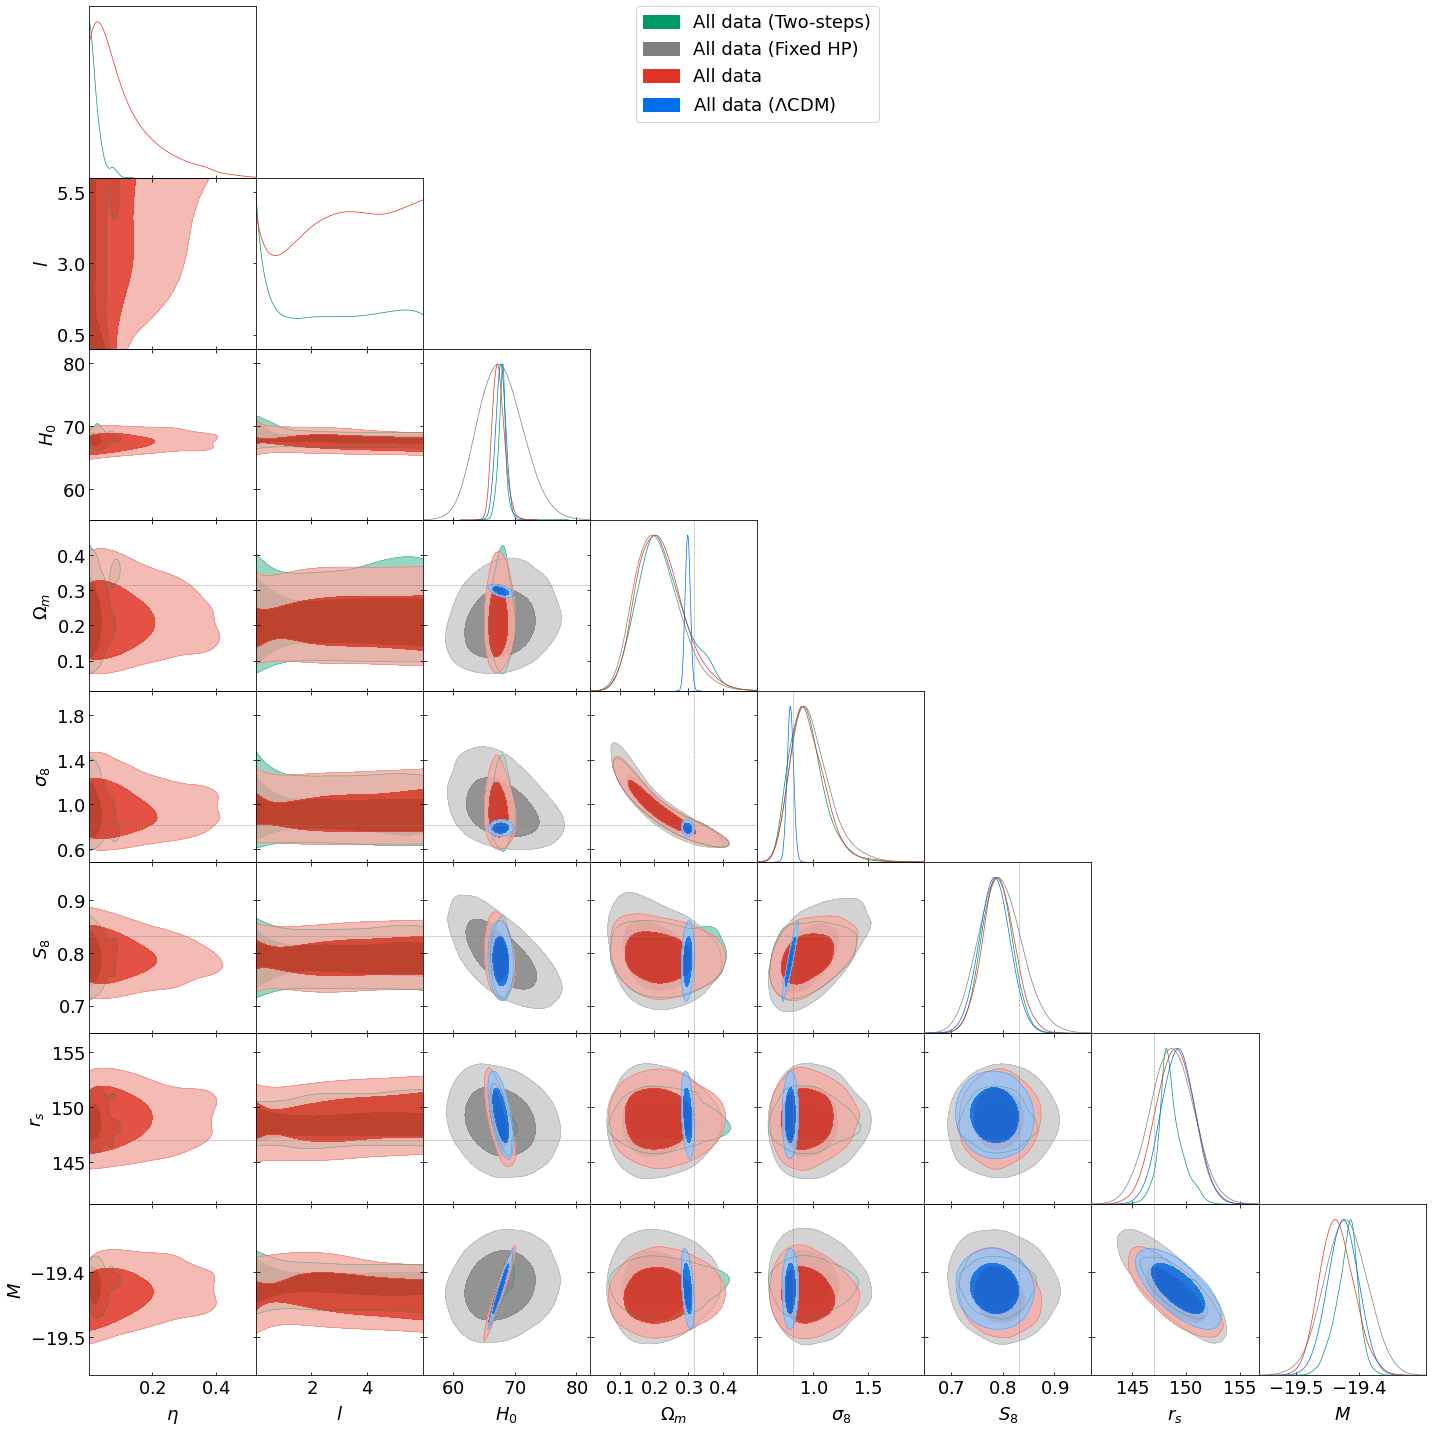

In [25]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.settings.axes_fontsize = 20
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.triangle_plot([All_CMB_noA0_samples, All_CMB_hp_samples, All_CMB_samples, Fiducial_LCDM_samples],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         'rd':147.06546072,
                         'M': -19.2})
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_tests.pdf')     

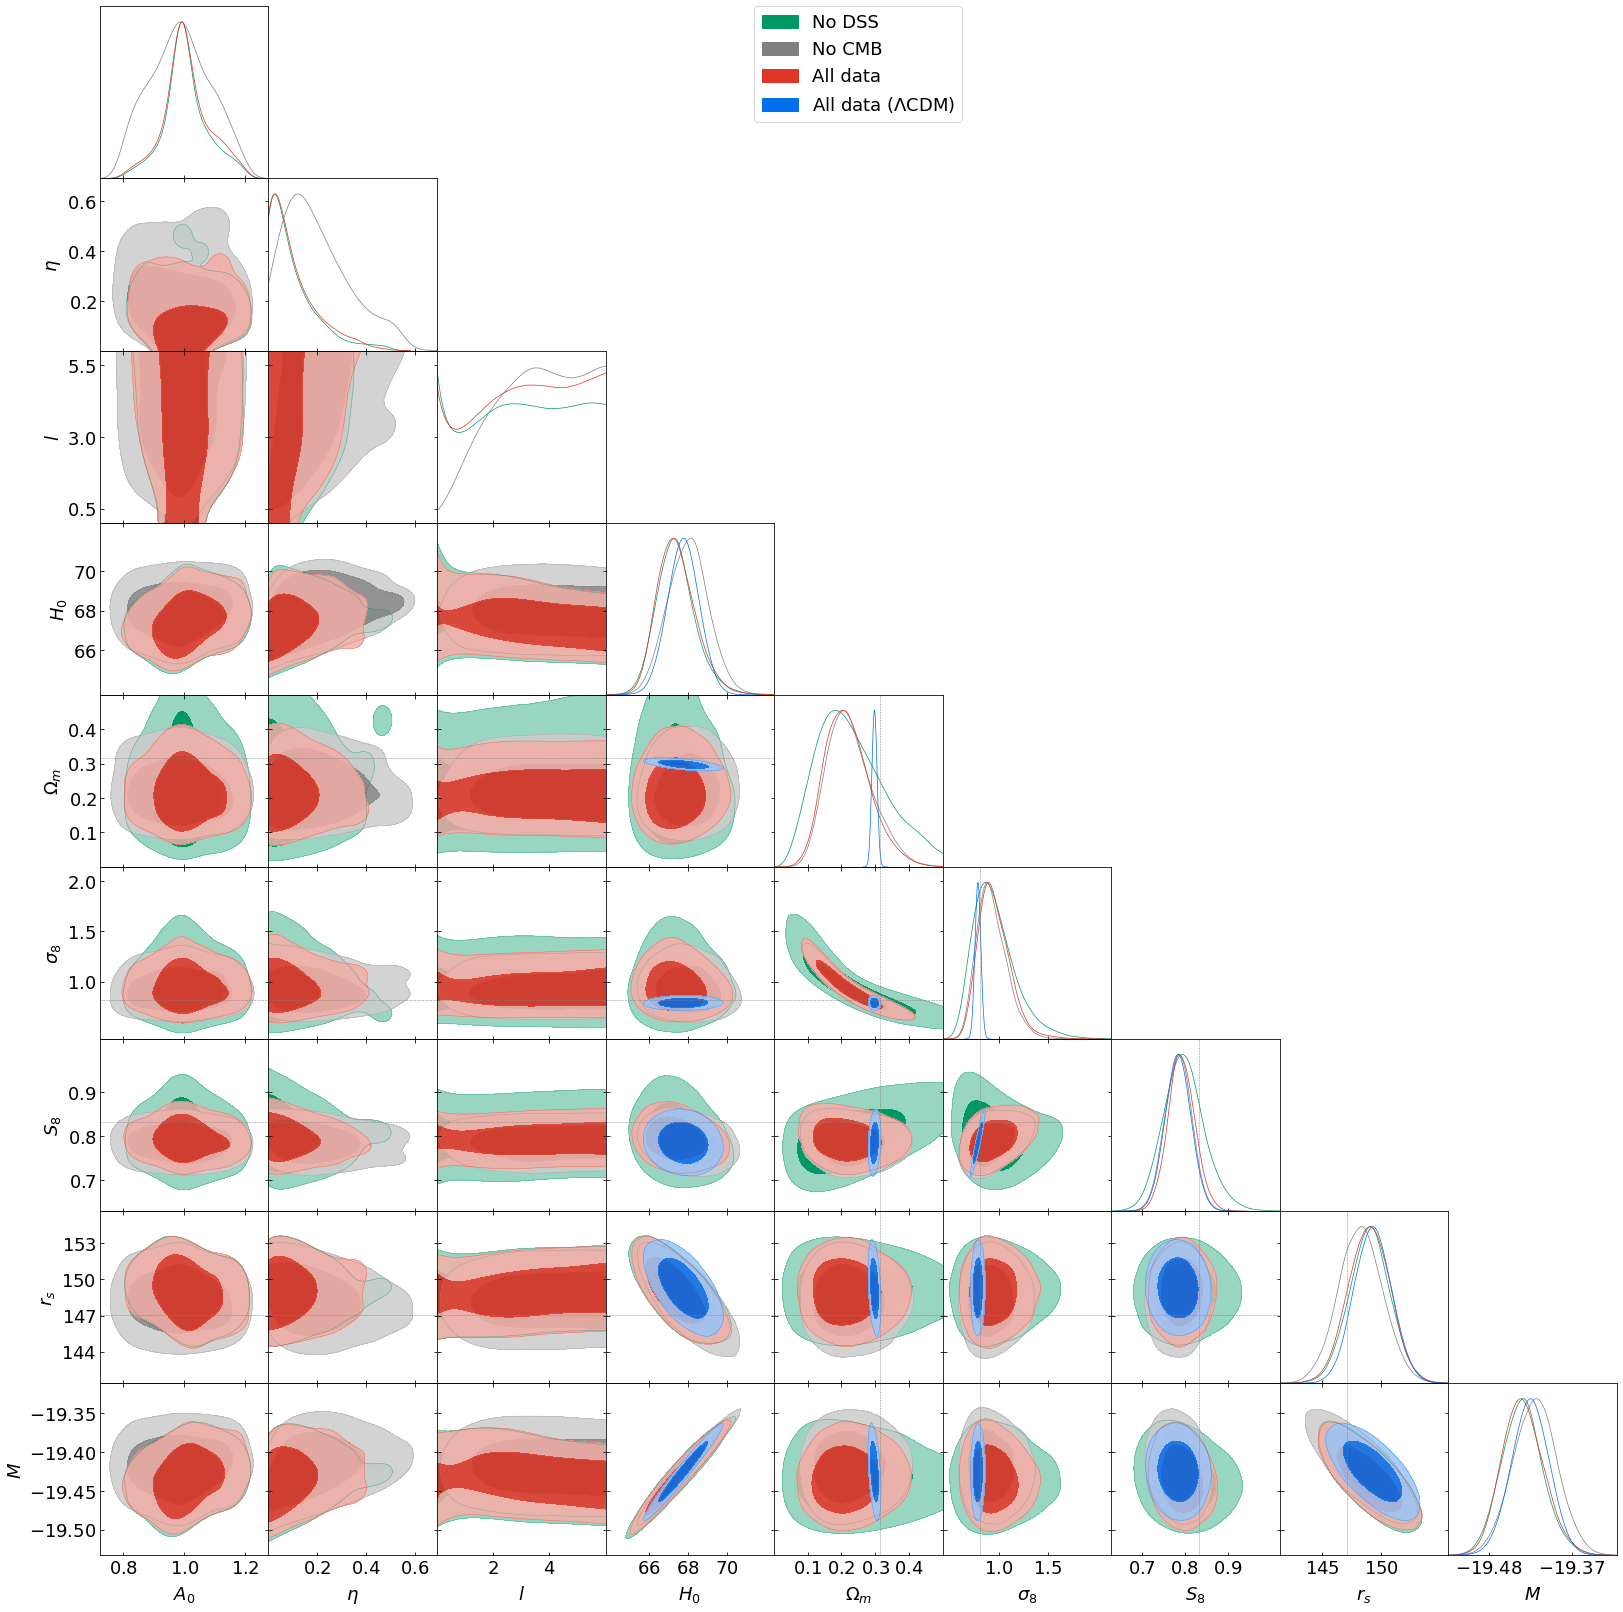

In [26]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.settings.axes_fontsize = 20
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.triangle_plot([All_CMB_NODSS_samples, All_samples, All_CMB_samples, Fiducial_LCDM_samples],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         'rd':147.06546072,
                         'M': -19.2})
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_data.pdf')

## Challenge

In [27]:
def challenge_1(cosmo):
    base_path = os.path.join('/home/jaime/PhD/Growz/data/outputs/finals/challenge/', cosmo)
    challenges = [f for f in listdir(base_path) if '.yml' not in f]#(not isfile(join(base_path, f))) or ('LCDM' not in f)]
    challenge_samples = []
    for challenge in challenges:
        path = os.path.join(base_path, challenge)+'/samples.npz'
        chain = np.load(path)#
        samples = make_samples(chain, ['A0', 'n', 'l', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd', 'M'], ranges2, challenge)
        challenge_samples.append(samples)
        with open(base_path+'/'+cosmo+'.yml') as f:
            ref = yaml.safe_load(f)
    g = plots.getSubplotPlotter(subplot_size=2.5)
    g.triangle_plot(challenge_samples,
                    ['H0_gp', 'Omega_m', 's80', 'S80'],
                filled=True,
                colors = ['red', 'grey', 'blue', 'green', 'magenta'],
                contour_colors = ['red', 'grey', 'blue', 'green', 'magenta'],
                markers={'H0_gp': ref['H0'],
                         'Omega_m': ref['Omega_m'],
                         's80': ref['sigma8'], 
                         'S80': ref['sigma8']*np.sqrt(ref['Omega_m']/0.3)})              
    g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle'+cosmo+'.pdf')
    return  

In [28]:
def challenge_2(cosmo, ppath='/home/jaime/PhD/Growz/data/outputs/finals/challenge/'):
    base_path = os.path.join(ppath, cosmo)
    challenges = [f for f in listdir(base_path) if '.yml' not in f]#(not isfile(join(base_path, f))) or ('LCDM' not in f)]
    challenge_samples = []
    ranges_c = {'Omega_m':[0.00, 0.7], 'H0_gp':[60.0, 80.0], 's80':[0.0, 1.2], 'S80':[0.0, 1.0]}
    for challenge in challenges:
        path = os.path.join(base_path, challenge)+'/samples.npz'
        chain = np.load(path)
        samples = make_samples(chain, ['A0', 'n', 'l', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd', 'M'], ranges2, challenge)
        challenge_samples.append(samples)
        with open(base_path+'/'+cosmo+'.yml') as f:
            ref = yaml.safe_load(f)
    g = plots.get_subplot_plotter(width_inch=15)
    g.settings.axes_fontsize = 16
    g.settings.legend_fontsize = 16
    g.settings.axes_labelsize = 16
    g.plots_1d(challenge_samples,
                ['H0_gp', 'Omega_m', 's80', 'S80'],
                nx=4,
                legend_ncol=2,
                share_y=True,
                markers={'H0_gp': ref['H0'],
                         'Omega_m': ref['Omega_m'],
                         's80': ref['sigma8'], 
                         'S80': ref['sigma8']*np.sqrt(ref['Omega_m']/0.3)}) 
    g.add_legend([cosmo], legend_loc='upper right')
    g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle'+cosmo+'.pdf')
    return  

Removed no burn in


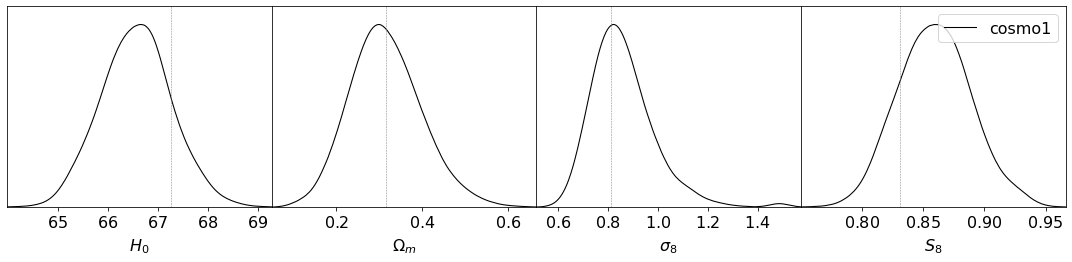

In [29]:
challenge_2('cosmo1')

Removed no burn in


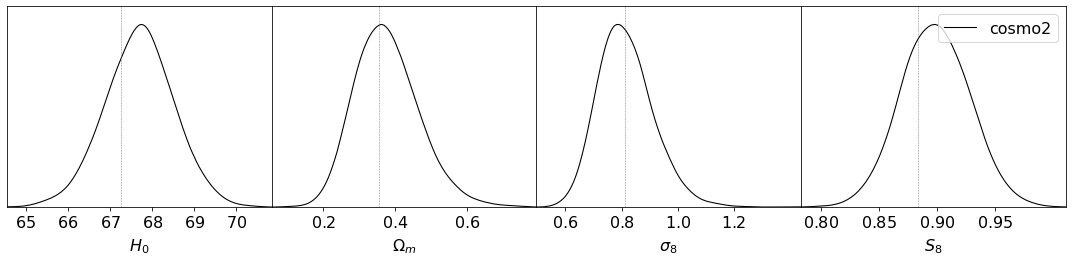

In [30]:
challenge_2('cosmo2')

Removed no burn in


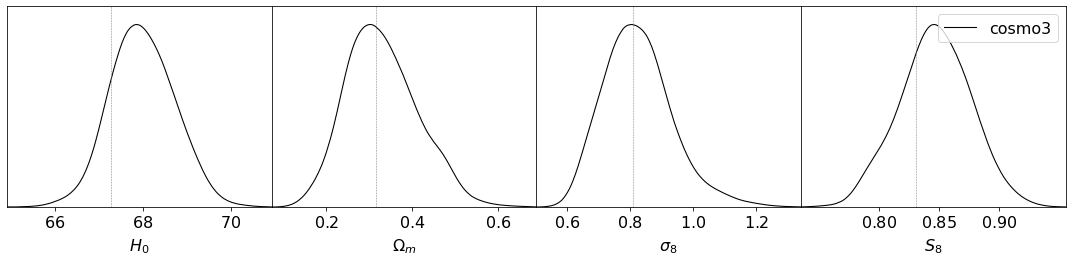

In [31]:
challenge_2('cosmo3')

Removed no burn in


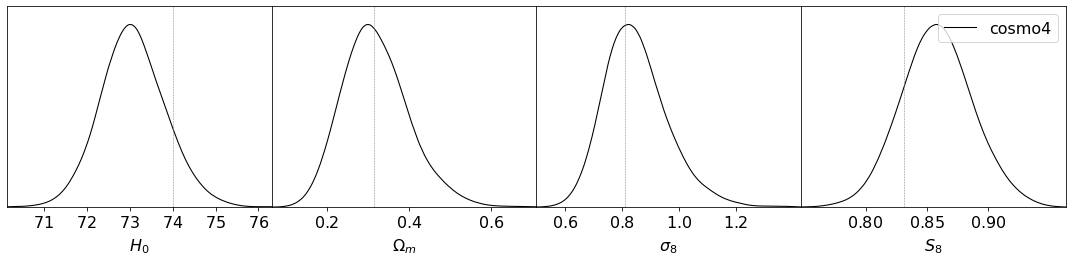

In [32]:
challenge_2('cosmo4', ppath='/home/jaime/PhD/Growz/data/outputs/reruns/challenge/')

Removed no burn in


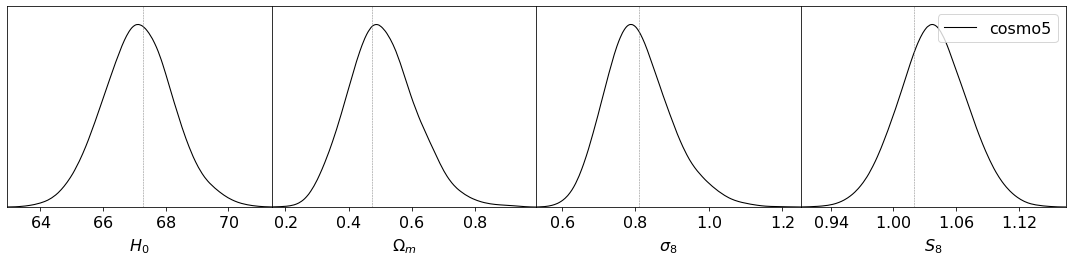

In [33]:
challenge_2('cosmo5')

# d_H gp 

In [34]:
dH_DESI_CMB_m, dH_DESI_CMB_s = get_m_s(DESI_CMB['DHz'])
dH_DESI_CMB2_m, dH_DESI_CMB2_s = get_m_s(DESI_CMB2['DHz'])
dH_All_CMB_m, dH_All_CMB_s = get_m_s(All_CMB['DHz'])
dH_All_CMB2_m, dH_All_CMB2_s = get_m_s(All_CMB2['DHz'])
dH_All_CMB_90_m, dH_All_CMB_90_s = get_m_s(All_CMB_90['DHz'])
dH_All_CMB_noA0_m, dH_All_CMB_noA0_s = get_m_s(All_CMB_noA0['DHz'])
dH_All_CMB_bfWms8_m, dH_All_CMB_bfWms8_s = get_m_s(All_CMB_bfWms8['DHz'])

dH_All_gro_m, dH_All_gro_s = get_m_s(All_gro['DHz'])
dH_All_CMB_geo_m, dH_All_CMB_geo_s = get_m_s(All_CMB_geo['DHz'])
dH_All_CMB_geo2_m, dH_All_CMB_geo2_s = get_m_s(All_CMB_geo2['DHz'])
dH_All_CMB_hp_m, dH_All_CMB_hp_s = get_m_s(All_CMB_hp['DHz'])

dH_All_m, dH_All_s = get_m_s(All['DHz'])
dH_All_CMB_NODSS_m, dH_All_CMB_NODSS_s = get_m_s(All_CMB_NODSS['DHz'])
dH_LCDM_m, dH_LCDM_s = get_m_s(1-fiducial_LCDM['Hz']/np.mean(fiducial_LCDM['Hz'], 0))

#Planck = data_class.Planck

/tmp/ipykernel_6987/904880703.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)
/tmp/ipykernel_6987/904880703.py:36: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)
/tmp/ipykernel_6987/904880703.py:71: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)
/tmp/ipykernel_6987/904880703.py:82: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_geo_vs_gro.pdf', box_inches='tight', pad_inches=0)


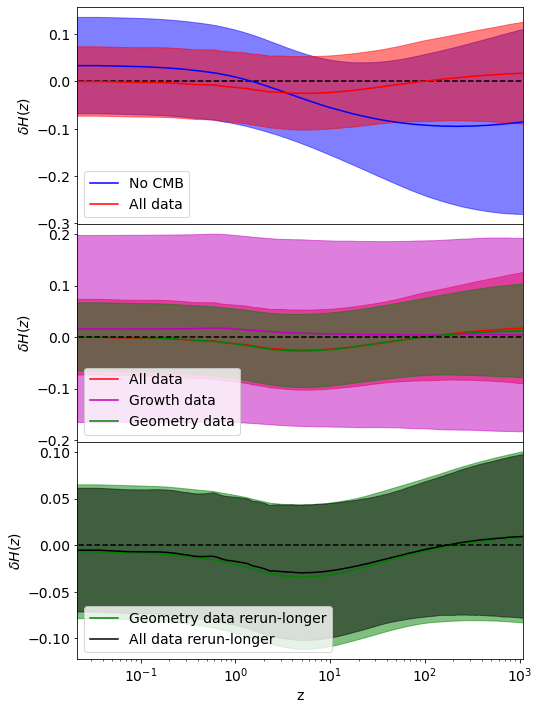

In [35]:
fig=plt.figure(figsize=(8,12))
fig.subplots_adjust(hspace=0)
ax1 = plt.subplot(311)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--')
plt.plot(z_arr,  dH_All_m, color ='b', label='No CMB')
plt.fill_between(z_arr, dH_All_m+dH_All_s,
                 dH_All_m-dH_All_s, color='b', alpha=.5)
plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='All data')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z", fontsize=14 )
plt.ylabel(r"$ \delta H(z)$", fontsize=14)
plt.legend(loc='lower left')
plt.setp( ax1.get_xticklabels(), visible=False)
plt.yticks(fontsize=14)

ax2 = plt.subplot(312, sharex = ax1)
plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='All data')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_All_gro_m, color ='m', label='Growth data')
plt.fill_between(z_arr, dH_All_gro_m+dH_All_gro_s,
                 dH_All_gro_m-dH_All_gro_s, color='m', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_geo_m, color ='g', label='Geometry data')
plt.fill_between(z_arr, dH_All_CMB_geo_m+dH_All_CMB_geo_s,
                 dH_All_CMB_geo_m-dH_All_CMB_geo_s, color='g', alpha=.5)
plt.plot(z_planck, np.zeros_like(z_planck), 'k--')

plt.xscale('log')
plt.xlim(0, 1100)
#plt.ylim(-.04, .04)
plt.xlabel("z", fontsize=14 )
plt.ylabel(r"$ \delta H(z)$", fontsize=14)
#plt.title(r"$\delta H(z)$")
plt.legend(loc='lower left')
plt.setp( ax2.get_xticklabels(), visible=False)
plt.yticks(fontsize=14)

ax3 = plt.subplot(313, sharex = ax1)
#plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='Fiducial')
#plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
#                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_geo2_m, color ='g', label='Geometry data rerun-longer')
plt.fill_between(z_arr, dH_All_CMB_geo2_m+dH_All_CMB_geo2_s, dH_All_CMB_geo2_m-dH_All_CMB_geo2_s, color='g', alpha=.5)
plt.plot(z_arr,  dH_All_CMB2_m, color ='k', label='All data rerun-longer')
plt.fill_between(z_arr, dH_All_CMB2_m+dH_All_CMB2_s, dH_All_CMB2_m-dH_All_CMB2_s, color='k', alpha=.5)

#plt.plot(z_arr,  dH_All_CMB_geo2_m, color ='g', label='Geometry data - longer')
#plt.fill_between(z_arr, dH_All_CMB_geo2_m+dH_All_CMB_geo2_s,
#                 dH_All_CMB_geo2_m-dH_All_CMB_geo2_s, color='g', alpha=.5)
#plt.plot(z_arr,  dH_All_CMB_bfWms8_m, color ='k', label='All data (BF $\Omega_m$ $\sigma_8$)')
#plt.fill_between(z_arr, dH_All_CMB_bfWms8_m+dH_All_CMB_bfWms8_s,
#                 dH_All_CMB_bfWms8_m-dH_All_CMB_bfWms8_s, color='k', alpha=.5)
#plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='Fiducial')
#plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
#                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)
#plt.plot(z_arr,  dH_All_CMB_NODSS_m, color ='r', label='Fiducial')
#plt.fill_between(z_arr, dH_All_CMB_NODSS_m+dH_All_CMB_NODSS_s,
#                 dH_All_CMB_NODSS_m-dH_All_CMB_NODSS_s, color='r', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--')

plt.xscale('log')
plt.xlim(0, 1100)
#plt.ylim(-.04, .04)
plt.xlabel("z", fontsize=14 )
plt.ylabel(r"$ \delta H(z)$", fontsize=14)
plt.legend(loc='lower left')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_geo_vs_gro.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_geo_vs_gro.pdf', box_inches='tight', pad_inches=0)  

/tmp/ipykernel_6987/214002429.py:13: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


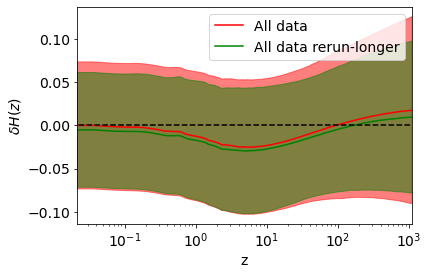

In [36]:
plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='All data')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_All_CMB2_m, color ='g', label='All data rerun-longer')
plt.fill_between(z_arr, dH_All_CMB2_m+dH_All_CMB2_s,
                 dH_All_CMB2_m-dH_All_CMB2_s, color='g', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--')


plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_tests.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_tests.pdf', bbox_inches='tight',  pad_inches=0)  

/tmp/ipykernel_6987/2275452178.py:21: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


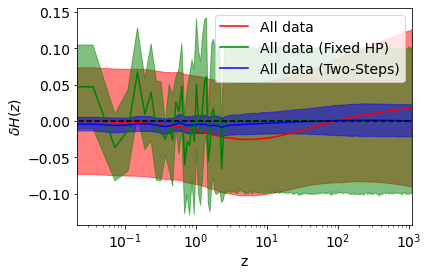

In [37]:
plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='All data')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_hp_m, color ='g', label='All data (Fixed HP)')
plt.fill_between(z_arr, dH_All_CMB_hp_m+dH_All_CMB_hp_s,
                 dH_All_CMB_hp_m-dH_All_CMB_hp_s, color='g', alpha=.5)

#plt.plot(z_arr,  dH_All_CMB_hp_m, color ='k', label='Fixed HP')
#plt.fill_between(z_arr, dH_All_CMB_hp_m+dH_All_CMB_hp_s,
#                 dH_All_CMB_hp_m-dH_All_CMB_hp_s, color='k', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_noA0_m, color ='b', label='All data (Two-Steps)')
plt.fill_between(z_arr, dH_All_CMB_noA0_m+dH_All_CMB_noA0_s,
                 dH_All_CMB_noA0_m-dH_All_CMB_noA0_s, color='b', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--')


plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_tests.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_tests.pdf', bbox_inches='tight',  pad_inches=0)  

/tmp/ipykernel_6987/3573428635.py:16: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


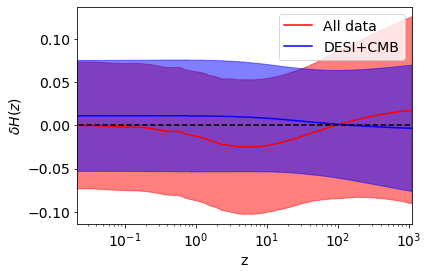

In [38]:
#fig=plt.figure(figsize=(6*(7/8),8*(7/8)))
#fig.subplots_adjust(hspace=0)
#ax1 = plt.subplot(211)

plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='All data')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_DESI_CMB_m, color ='b', label='DESI+CMB')
plt.fill_between(z_arr, dH_DESI_CMB_m+dH_DESI_CMB_s,
                 dH_DESI_CMB_m-dH_DESI_CMB_s, color='b', alpha=.5)
plt.plot(z_planck, np.zeros_like(z_planck), 'k--')


plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.setp( ax1.get_xticklabels(), visible=False)
plt.legend();

#ax2=plt.subplot(212)

#plt.plot(z_arr, np.std(np.transpose(DESI_CMB['Hz']/data_class.H_arr)/DESI_CMB['A0']-1, 1), 'b', label='GP - DESI+CMB')
#plt.fill_between(z_arr,np.std(np.transpose(DESI_CMB['Hz']/data_class.H_arr)/DESI_CMB['A0']-1, 1), 0, color='b', alpha=0.5)

#plt.plot(z_arr, np.std(np.transpose(fiducial_LCDM['Hz']/np.mean(fiducial_LCDM['Hz'], 0))-1, 1), 'g', label='$\Lambda$CDM - Current data')
#plt.fill_between(z_arr, np.std(np.transpose(fiducial_LCDM['Hz']/np.mean(fiducial_LCDM['Hz'], 0))-1, 1), 0, color='g', alpha=0.5)

#plt.xscale('log')
#plt.ylabel(r"$ \delta H(z)$")
#plt.xlabel('z')
#plt.legend()
#plt.xlim(0, 1100)
#plt.ylim(0, 0.037);

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf', bbox_inches='tight',  pad_inches=0)  

/tmp/ipykernel_6987/3538546436.py:12: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


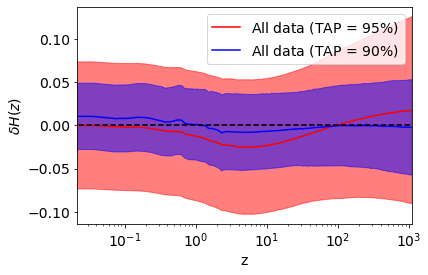

In [39]:
plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='All data (TAP = $95\%$)')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_90_m, color ='b', label='All data (TAP = $90\%$)')
plt.fill_between(z_arr, dH_All_CMB_90_m+dH_All_CMB_90_s,
                 dH_All_CMB_90_m-dH_All_CMB_90_s, color='b', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--')

plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/90_vs_95.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/90_vs_95.pdf', bbox_inches='tight',  pad_inches=0)  

# H_gp, DM_gp and f$\sigma_8$_gp

## Load samples

In [40]:
H_DESI_CMB_m, H_DESI_CMB_s = get_m_s(DESI_CMB['Hz'])
H_All_CMB_m, H_All_CMB_s = get_m_s(All_CMB['Hz'])
H_All_CMB_noA0_m, H_All_CMB_noA0_s = get_m_s(All_CMB_noA0['Hz'])
H_All_CMB_hp_m, H_All_CMB_hp_s = get_m_s(All_CMB_hp['Hz'])
H_All_gro_m, H_All_gro_s = get_m_s(All_gro['Hz'])
H_All_m, H_All_s = get_m_s(All['Hz'])
H_All_CMB_NODSS_m, H_All_CMB_NODSS_s = get_m_s(All_CMB_NODSS['Hz'])

In [41]:
dM_DESI_CMB_m, dM_DESI_CMB_s = get_m_s(DESI_CMB['dMz'])
dM_All_CMB_m, dM_All_CMB_s = get_m_s(All_CMB['dMz'])
dM_All_CMB_noA0_m, dM_All_CMB_noA0_s = get_m_s(All_CMB_noA0['dMz'])
dM_All_CMB_hp_m, dM_All_CMB_hp_s = get_m_s(All_CMB_hp['dMz'])
dM_All_gro_m, dM_All_gro_s = get_m_s(All_gro['dMz'])
dM_All_m, dM_All_s = get_m_s(All['dMz'])
dM_All_CMB_NODSS_m, dM_All_CMB_NODSS_s = get_m_s(All_CMB_NODSS['dMz'])

In [42]:
fs8_DESI_CMB_m, fs8_DESI_CMB_s = get_m_s(DESI_CMB['fs8z'])
fs8_All_CMB_m, fs8_All_CMB_s = get_m_s(All_CMB['fs8z'])
fs8_All_CMB_noA0_m, fs8_All_CMB_noA0_s = get_m_s(All_CMB_noA0['fs8z'])
fs8_All_CMB_hp_m, fs8_All_CMB_hp_s = get_m_s(All_CMB_hp['fs8z'])
fs8_All_gro_m, fs8_All_gro_s = get_m_s(All_gro['fs8z'])
fs8_All_m, fs8_All_s = get_m_s(All['fs8z'])
fs8_All_CMB_NODSS_m, fs8_All_CMB_NODSS_s = get_m_s(All_CMB_NODSS['fs8z'])
fs8_All_CMB_bfWms8_m, fs8_All_CMB_bfWms8_s = get_m_s(All_CMB_bfWms8['fs8z'])

## Plots

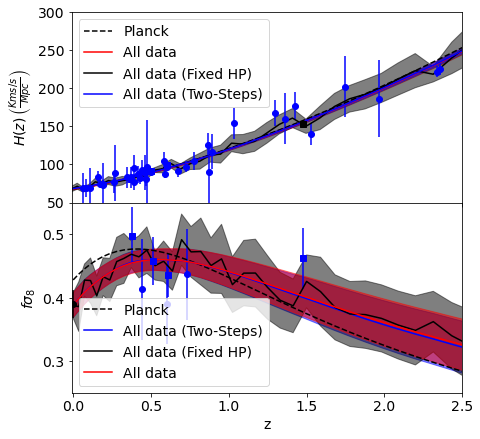

In [43]:
fig=plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(211)
plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')
plt.errorbar(CC_data['z'], CC_data['data'], yerr = CC_data['err'], fmt='bo')#, label='CC')
plt.errorbar(BOSS_data['z'], BOSS_data['para_data'], yerr=BOSS_data['para_err'], fmt='bs')#, label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], c/1000/(eBOSS_data['para_data']*eBOSS_data['rd']), 
             yerr = 1/eBOSS_data['rd']/(np.array([0.47])), fmt='ks')#, label='eBOSS DR16')

plt.plot(z_arr,  H_All_CMB_m, color ='r', label='All data')
plt.fill_between(z_arr, H_All_CMB_m+H_All_CMB_s, H_All_CMB_m-H_All_CMB_s, color='r', alpha=.5)
plt.plot(z_arr,  H_All_CMB_hp_m, color ='k', label='All data (Fixed HP)')
plt.fill_between(z_arr, H_All_CMB_hp_m+H_All_CMB_hp_s,
                 H_All_CMB_hp_m-H_All_CMB_hp_s, color='k', alpha=.5)
plt.plot(z_arr,  H_All_CMB_noA0_m, color ='b', label='All data (Two-Steps)')
plt.fill_between(z_arr, H_All_CMB_noA0_m+H_All_CMB_noA0_s,
                 H_All_CMB_noA0_m-H_All_CMB_noA0_s, color='b', alpha=.5)
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.xticks(visible=False)
plt.legend();

#ax2 = plt.subplot(132)
#plt.plot(z_planck, Planck['dM_arr'], 'k--', label='Planck')
#plt.errorbar(DS17_data['z'], (10**((DS17_data['data']-25+19.49)/5))/(1+DS17_data['z']),
#             yerr=(10**(DS17_data['err']/5))/(1+DS17_data['z']), fmt='ko', label='DS17')
#plt.errorbar(BOSS_data['z'], BOSS_data['perp_data'], yerr=BOSS_data['perp_err'], fmt='ks', label='BOSS DR12')
#plt.errorbar(eBOSS_data['z'], eBOSS_data['perp_data']*eBOSS_data['rd'],
#             yerr=np.array([0.79])*eBOSS_data['rd'], fmt='ks', label='eBOSS DR16')
#plt.errorbar(CMB_data['z'], (1/CMB_data['data'])*(100*CMB_data['rd']),
#
#plt.plot(z_arr,  dM_All_CMB_m, color ='r', label='All data')
#plt.fill_between(z_arr, dM_All_CMB_m+dM_All_CMB_s, dM_All_CMB_m-dM_All_CMB_s, color='r', alpha=.5)
#plt.plot(z_arr,  dM_All_CMB_hp_m, color ='k', label='Fixed HP')
#plt.fill_between(z_arr, dM_All_CMB_hp_m+dM_All_CMB_hp_s,
#                 dM_All_CMB_hp_m-dM_All_CMB_hp_s, color='k', alpha=.5)
#plt.plot(z_arr,  dM_All_CMB_noA0_m, color ='b', label='Hierarchical')
#plt.fill_between(z_arr, dM_All_CMB_noA0_m+dM_All_CMB_noA0_s,
#                dM_All_CMB_noA0_m-dM_All_CMB_noA0_s, color='b', alpha=.5)

#plt.xlabel("z")
#plt.xscale('log')
#plt.yscale('log')
#plt.ylabel(r"$D_M$")
#plt.title(r"$D_M \, (Mpc)$")
#plt.legend();

ax3 = plt.subplot(212)
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='bs')#, label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='bs')#, label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='bo')#, label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='ko')#, label='DSS')


plt.plot(z_arr,  fs8_All_CMB_noA0_m, color ='b', label='All data (Two-Steps)')
plt.fill_between(z_arr, fs8_All_CMB_noA0_m+fs8_All_CMB_noA0_s,
                 fs8_All_CMB_noA0_m-fs8_All_CMB_noA0_s, color='b', alpha=.5)
plt.plot(z_arr,  fs8_All_CMB_hp_m, color ='k', label='All data (Fixed HP)')
plt.fill_between(z_arr, fs8_All_CMB_hp_m+fs8_All_CMB_hp_s,
                 fs8_All_CMB_hp_m-fs8_All_CMB_hp_s, color='k', alpha=.5)
plt.plot(z_arr,  fs8_All_CMB_m, color ='r', label='All data')
plt.fill_between(z_arr, fs8_All_CMB_m+fs8_All_CMB_s,
                 fs8_All_CMB_m-fs8_All_CMB_s, color='r', alpha=.5)


plt.xlim(-0.01, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.legend();



os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/tests_cosmo_functions.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/tests_cosmo_functions.pdf', bbox_inches='tight',  pad_inches=0)   

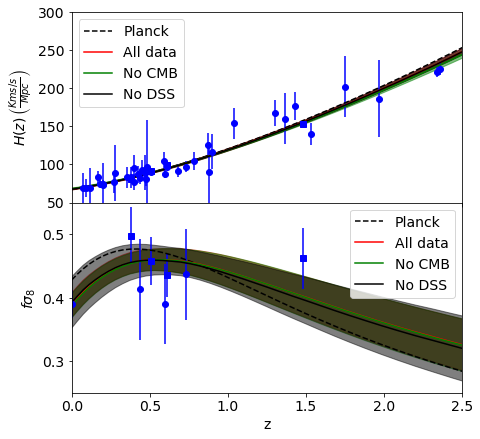

In [44]:
fig=plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(211)
plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')

plt.errorbar(CC_data['z'], CC_data['data'], yerr = CC_data['err'], fmt='bo')#, label='CC')
plt.errorbar(BOSS_data['z'], BOSS_data['para_data'], yerr=BOSS_data['para_err'], fmt='bs')#, label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], c/1000/(eBOSS_data['para_data']*eBOSS_data['rd']), 
             yerr = 1/eBOSS_data['rd']/(np.array([0.47])), fmt='bs')#, label='eBOSS DR16')
plt.plot(z_arr,  H_All_CMB_m, color ='r', label='All data')
plt.fill_between(z_arr, H_All_CMB_m+H_All_CMB_s,
                 H_All_CMB_m-H_All_CMB_s, color='r', alpha=.5)
plt.plot(z_arr,  H_All_m, color ='g', label='No CMB')
plt.fill_between(z_arr, H_All_m+H_All_s, 
                 H_All_m-H_All_s, color='g', alpha=.5)
plt.plot(z_arr,  H_All_CMB_NODSS_m, color ='k', label='No DSS')
plt.fill_between(z_arr, H_All_CMB_NODSS_m+H_All_CMB_NODSS_s,
                 H_All_CMB_NODSS_m-H_All_CMB_NODSS_s, color='k', alpha=.5)
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.xticks(visible=False)
plt.legend();

#ax2 = plt.subplot(132)
#plt.plot(z_planck, Planck['dM_arr'], 'k--', label='Planck')
#plt.errorbar(DS17_data['z'], (10**((DS17_data['data']-25+19.49)/5))/(1+DS17_data['z']),
#             yerr=(10**(DS17_data['err']/5))/(1+DS17_data['z']), fmt='bo', label='DS17')
#plt.errorbar(BOSS_data['z'], BOSS_data['perp_data'], yerr=BOSS_data['perp_err'], fmt='bs', label='BOSS DR12')
#plt.errorbar(eBOSS_data['z'], eBOSS_data['perp_data']*eBOSS_data['rd'],
#             yerr=np.array([0.79])*eBOSS_data['rd'], fmt='bs', label='eBOSS DR16')
#plt.errorbar(CMB_data['z'], (1/CMB_data['data'])*(100*CMB_data['rd']),
#             yerr=(1/CMB_data['err'])*1/(100*CMB_data['rd']), fmt='bo', label='CMB')
#plt.plot(z_arr,  dM_All_CMB_m, color ='r', label='All data')
#plt.fill_between(z_arr, dM_All_CMB_m+dM_All_CMB_s,
#                 dM_All_CMB_m-dM_All_CMB_s, color='r', alpha=.5)
#plt.plot(z_arr,  dM_All_m, color ='g', label='No CMB')
#plt.fill_between(z_arr, dM_All_m+dM_All_s, 
#                 dM_All_m-dM_All_s, color='g', alpha=.5)
#plt.plot(z_arr,  dM_All_CMB_NODSS_m, color ='k', label='No DSS')
#plt.fill_between(z_arr, dM_All_CMB_NODSS_m+dM_All_CMB_NODSS_s,
#                 dM_All_CMB_NODSS_m-dM_All_CMB_NODSS_s, color='k', alpha=.5)
#plt.xlabel("z")
#plt.ylabel(r"$D_M$")
#plt.xscale('log')
#plt.yscale('log')
#plt.title(r"$D_M \, (Mpc)$")
#plt.legend();

ax2 = plt.subplot(212)
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='bs')#, label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='bs')#, label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='bo')#, label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='bo')#, label='DSS')
plt.plot(z_arr,  fs8_All_CMB_m, color ='r', label='All data')
plt.fill_between(z_arr, fs8_All_CMB_m+fs8_All_CMB_s,
                 fs8_All_CMB_m-fs8_All_CMB_s, color='r', alpha=.5)
plt.plot(z_arr,  fs8_All_m, color ='g', label='No CMB')
plt.fill_between(z_arr, fs8_All_m+fs8_All_s, 
                 fs8_All_m-fs8_All_s, color='g', alpha=.5)
plt.plot(z_arr,  fs8_All_CMB_NODSS_m, color ='k', label='No DSS')
plt.fill_between(z_arr, fs8_All_CMB_NODSS_m+fs8_All_CMB_NODSS_s,
                 fs8_All_CMB_NODSS_m-fs8_All_CMB_NODSS_s, color='k', alpha=.5)

plt.xlim(-0.001, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/data_cosmo_functions.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/data_cosmo_functions.pdf', bbox_inches='tight',  pad_inches=0)  

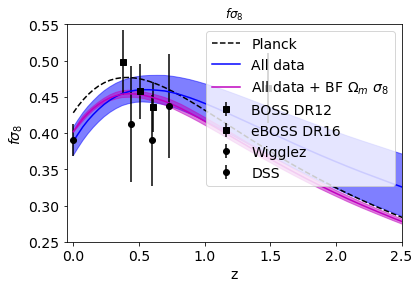

In [45]:
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='ks', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='ko', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='ko', label='DSS')

plt.plot(z_arr,  fs8_All_CMB_m, color ='b', label='All data')
plt.fill_between(z_arr, fs8_All_CMB_m+fs8_All_gro_s,
                 fs8_All_CMB_m-fs8_All_CMB_s, color='b', alpha=.5)

plt.plot(z_arr,  fs8_All_CMB_bfWms8_m, color ='m', label='All data + BF $\Omega_m$ $\sigma_8$')
plt.fill_between(z_arr, fs8_All_CMB_bfWms8_m+fs8_All_CMB_bfWms8_s,
                 fs8_All_CMB_bfWms8_m-fs8_All_CMB_bfWms8_s, color='m', alpha=.5)


plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_Wms8_effect.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_Wms8_effect.pdf', bbox_inches='tight',  pad_inches=0)  

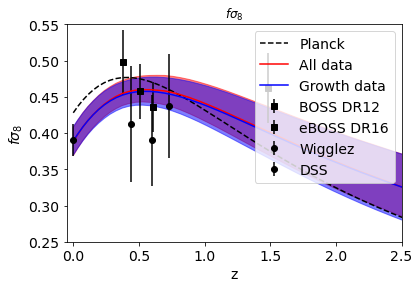

In [46]:
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='ks', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='ko', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='ko', label='DSS')

plt.plot(z_arr,  fs8_All_CMB_m, color ='r', label='All data')
plt.fill_between(z_arr, fs8_All_CMB_m+fs8_All_gro_s,
                 fs8_All_CMB_m-fs8_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  fs8_All_gro_m, color ='b', label='Growth data')
plt.fill_between(z_arr, fs8_All_gro_m+fs8_All_gro_s,
                 fs8_All_gro_m-fs8_All_gro_s, color='b', alpha=.5)


plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_wm_effect.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_wm_effect.pdf', bbox_inches='tight',  pad_inches=0)  